In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Model

In [185]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from weather import Weather
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

weather = Weather().get_data()
weather = Weather().clean_data(weather)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_term','summit_date1', 'summit_bid',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')
exped['rope'] = np.where(exped['rope']>0, True, False)

exped = exped.set_index('summit_date')
weather = weather.set_index('date_time')

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])

weather['pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['pressure_futur'] - weather['pressure_past']

# Merge DataFrames
df = exped.merge(weather, how='left', left_index=True, right_index=True)
df = df.reset_index()
df = df.rename(columns={'index' : 'summit_date'})
df = df.merge(member, on='exp_id', how = 'right')
df = df.dropna(subset=['summit_date', 'bc_date'])

# Feature Engineering (2/2)
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = weather.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow
    
feature_to_drop = ['tempC', 'WindChillC', 'primrte', 'disabled','moonrise', 'moonset', 
                   'sunrise', 'sunset', 'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason', 'tot_days',
                   'pressure_past', 'pressure_futur', 'uvIndex', 'o2_used', 'date_season']

df.drop(columns= feature_to_drop, inplace=True)

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class BoolImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3)

In [79]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [80]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.80      0.83      2287
        True       0.77      0.82      0.80      1855

    accuracy                           0.81      4142
   macro avg       0.81      0.81      0.81      4142
weighted avg       0.81      0.81      0.81      4142



## Test with new data

In [6]:
test = X.reset_index()
test = test.iloc[[1122]]
test1 = X.reset_index()
test1 = test1.iloc[[1122]]

In [7]:
test['rope'] = True
test['camps'] = 5
test['summit_days'] = 20

test1['rope'] = False
test1['camps'] = 2
test1['summit_days'] = 10

In [8]:
X_trans = clf.transform(test)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.02564985, 0.97435015]], dtype=float32)

In [9]:
X_trans = clf.transform(test1)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.42166865, 0.57833135]], dtype=float32)

## Features

### Feature Importance

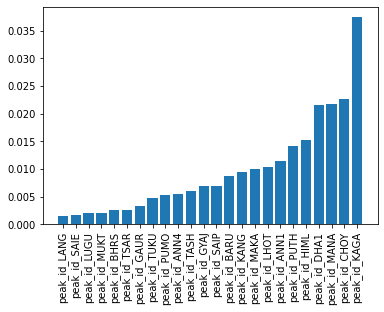

In [10]:
# feature importance
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
dfeat = dfeat[dfeat['feature'].str.contains('peak_id')]
dfeat = dfeat.sort_values(by='value')

val = 0
# plot
plt.bar(dfeat.loc[dfeat['value']> val , 'feature'], dfeat.loc[dfeat['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

NameError: name 'font' is not defined

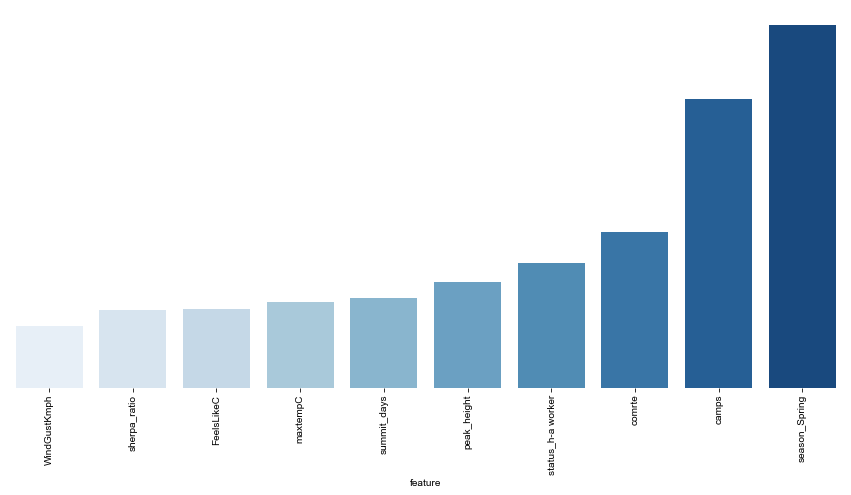

In [11]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

palette = sns.color_palette("Blues_r", n_colors=10)
palette.reverse()

plt.figure(figsize=(15,7))
sns.barplot(x=df_feat_2.tail(10)['feature'], y=df_feat_2.tail(10)['value'], palette=palette)
plt.xticks(rotation=90)
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True, left=True)
plt.yticks([])
plt.ylabel('')
plt.title('Features Importance Without O2 Used', fontdict = font)
plt.show()

In [ ]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16}

x, y, hue = "comrte", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Commercial Route', fontdict=font)
plt.show()

In [ ]:
x, y, hue = "status", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Status', fontdict=font)
plt.show()

In [ ]:
sns.boxplot(y=df["peak_height"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Peak Height')
plt.show()

In [ ]:
x, y, hue = "season", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

field = "season"
day_order = ["Spring", "Summer", "Autumn", "Winter"]
prop_df = prop_df.set_index(field).loc[day_order]

sns.barplot(x=prop_df.index, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Season', fontdict=font)
plt.legend().remove()
plt.show()

In [ ]:
sns.boxplot(y=df["summit_days"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Summit Days')
plt.show()

In [ ]:
sns.boxplot(y=df["camps"],x=df['summit_success'], palette="Blues_r")
plt.ylim((0,10))
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Number of Camps')
plt.show()

In [ ]:
x, y, hue = "no_hired", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Hired Sherpas', fontdict=font)
plt.show()

### Feature permutation

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(boost, X_test, y_test)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()

Y = list(sorted_idx)
sorted_feat = [x for _,x in sorted(zip(Y,feature_names))]

dfeat_prem = pd.DataFrame(data=perm_importance.importances_mean[sorted_idx])
dfeat_prem['feature'] = sorted_feat
dfeat_prem.columns = ['value', 'feature']
dfeat_prem = dfeat_prem.sort_values(by='value')
dfeat_prem = dfeat_prem[~dfeat_prem['feature'].str.contains('peak')]
dfeat_prem = dfeat_prem[dfeat_prem['value']!=0]


val = 0.005
# plot
plt.bar(dfeat_prem.feature, dfeat_prem.value)
plt.xticks(rotation=90)
plt.show()

In [ ]:
import shap
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names= feature_names)

## Other Models

In [ ]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=500)
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1


def initialize_model():
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(176,)))
    model.add(layers.Dense(200, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(100, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights=True)

model_NN = initialize_model()

history = model_NN.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= 300, 
                    batch_size=8,
                    verbose=0,
                   callbacks = [es])

y_pred_NN = model_NN.predict_classes(X_test)
print(classification_report(y_test, y_pred_NN))

## RandomSearchCV

### XGB

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {'booster' : ['gbtree', 'gblinear'],
        'min_child_weight': [0.1, 1, 5, 10, 50],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 25, 50],
        'learning_rate': [0.0001, 0.001, 0.1, 1],
        'n_estimators': [50, 100, 250, 500],
        'reg_alpha': [0.0001, 0.001, 0.1, 1],
        'reg_lambda': [0.0001, 0.001, 0.1, 1]
        }

model = XGBClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=0, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

In [ ]:
boost

In [ ]:
best_model = random_search.best_estimator_
best_model

In [ ]:
y_xgbCV = best_model.predict(X_test)
print(classification_report(y_test, y_xgbCV))

### RFC

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators' : [100,200,500],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split': [2, 3, 5],
        'max_depth': [5, 10, 25, 50],
        'min_samples_leaf': [1, 3, 5],
        'max_features': ["sqrt", "log2"]
        }

model = RandomForestClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

In [ ]:
best_RFC = random_search.best_estimator_

In [ ]:
best_RFC

In [ ]:
ypred = best_RFC.predict(X_test)
print(classification_report(y_test, ypred))

# Test xgb_model.py

In [1]:
from xgb_model import HimalXGB

model = HimalXGB().train_model()

In [4]:
to_predict = pd.DataFrame(columns=['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'age', 'cumul_snow'])
# peak_height = peak[peak['peak_id']==mountain]['height_m'].values[0]
# sherpa_ratio = total_members/total_hired
to_predict = to_predict.append({'peak_id':'EVER', 'host':'China', 'summit_days':18, 'camps':7, 'rope':bool("True"), 'tot_members':20,
       'tot_hired':7, 'no_hired':bool("False"), 'comrte': bool("True"), 'stdrte':bool("False"), 'peak_height':8000,
       'sherpa_ratio': 0.3 , 'maxtempC':-2.277021, 'mintempC': -9.736381, 'totalSnow_cm': 1.754977, 'sunHour': 10.275210,
       'moon_illumination': 48.470733, 'DewPointC' :-8.459432 , 'FeelsLikeC':-9.604752 , 'HeatIndexC': -5.661692,
       'WindGustKmph':13.669081, 'cloudcover': 45.633150, 'humidity': 81.966314, 'precipMM': 2.532628, 'pressure' : 1013.688569,
       'visibility':7.486308, 'winddirDegree':211.464793, 'windspeedKmph': 10.086931, 'stability': 0.045808, 'season' :"Spring",
       'sex_M': 1, 'status': "climber", 'age': 34, 'cumul_snow':43}, ignore_index=True)

In [5]:
y_pred = HimalXGB().predict_model(to_predict)
y_pred

array([[0.7708429 , 0.22915712, 0.        ]], dtype=float32)

# Model without weather

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_bid','summit_term','summit_date1',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])
exped['rope'] = np.where(exped['rope']>0, True, False)



# Merge DataFrames
df = exped.merge(member, on='exp_id', how = 'right')


feature_to_drop = ['primrte', 'disabled', 
                   'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason']

df.drop(columns= feature_to_drop, inplace=True)

In [ ]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [ ]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [ ]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

# plot
plt.figure(figsize=(15,7))
plt.bar(df_feat_2.feature, df_feat_2.value)
plt.xticks(rotation=90)
plt.show()

# Peaks GPS

In [ ]:
import pandas as pd

#gps = pd.read_excel('data/Peaks_GPS.xls')

gps = pd.read_excel('data/main_peaks.xlsx')

In [ ]:
import re

def coord(x):
    numbers = re.findall(r'\d+', x)
    unit = int(numbers[0])
    dec = int(numbers[1])/60
    cent = int(numbers[2])/3600
    
    return round(unit+dec+cent,4)

In [ ]:
gps['lat'] = gps['lat'].apply(lambda x: coord(x))
gps['lon'] = gps['lon'].apply(lambda x: coord(x))

In [ ]:
import folium

m = folium.Map(
    location=[27.98, 86.92],
    zoom_start=8,
    tiles='Stamen Terrain'
)

feature_group = folium.FeatureGroup("Locations")
for lat, lng, name in zip(gps.lat, gps.lon, gps.peak_name):
    feature_group.add_child(folium.Marker(location=[lat,lng], popup=name))

m.add_child(feature_group)

folium.Marker(
    location=[27.948056, 86.810278],
    popup='Weather Station',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)


m

# Dash

In [237]:
from data import Data

df = Data().get_matching_table()

In [259]:
peak, year, season = "Langmoche Ri", "2012", 'All'

In [260]:
if season=='All':
    season = ''

dff = df[(df.peak_name==peak)\
         &(df.year == int(year))\
         &(df.season.str.contains(season))]

alt = int(df.loc[df.peak_name==peak, 'peak_height'].mean())
climb = dff.shape[0]
if climb == 0:
    rate = 0
else:
    rate = round(len(dff[dff['summit_success']==True])/climb*100)
rate = f'{rate} %'

rate

'67 %'

In [274]:
df[df['peak_name']=='Dzanye II']

,summit_date,exp_id,peak_id,host,leaders,bc_date,summit_days,tot_days,camps,rope,...,high_point,o2_used,death,death_type,death_height,death_class,summit_bid,summit_term,age,cumul_snow
14822,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,21.0,87.9
14823,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,24.0,87.9
14824,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,21.0,87.9
14825,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,23.0,87.9
14826,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,20.0,87.9
14827,2015-10-04,DZA215301,DZA2,Nepal,Takanori Mashimo,2015-09-17,17,0,3,False,...,6318,False,False,Unspecified,0,Unspecified,Successful summit bid,Success,20.0,87.9


In [298]:
import dash_core_components as dcc

years = {i : str(i) for i in range(df.year.min(), df.year.max()+1)}
years.update({df.year.max()+1 : 'All'})

peak, year, season = 'Everest', '2010', 'Spring'

if year == 'All':
    dff = df[(df.peak_name==peak)\
                 &(df.year <= list(years.keys())[-1])\
                 &(df.season.str.contains(season))]
else:
    dff = df[(df.peak_name==peak)\
             &(df.year == int(year))\
             &(df.season.str.contains(season))]
    
dcc.Slider(
        id='input_year',
        min=df.year.min(),
        max='All',
        step=None,
        marks=years,
        value=df.year.max()
    )

Slider(id='input_year', marks={2010: '2010', 2011: '2011', 2012: '2012', 2013: '2013', 2014: '2014', 2015: '2015', 2016: '2016', 2017: 'All'}, value=2016, min=2010, max='All')

In [311]:
season_list = ['Spring', 'Summer', 'Autumn', 'Winter', 'All']
[{'label' : i, 'value' : str(i)} for i in season_list]

[{'label': 'Spring', 'value': 'Spring'},
 {'label': 'Summer', 'value': 'Summer'},
 {'label': 'Autumn', 'value': 'Autumn'},
 {'label': 'Winter', 'value': 'Winter'},
 {'label': 'All', 'value': 'All'}]

In [306]:
[
        {'label': 'New York City', 'value': 'NYC'},
        {'label': 'Montréal', 'value': 'MTL'},
        {'label': 'San Francisco', 'value': 'SF'}
    ]

[{'label': 'New York City', 'value': 'NYC'},
 {'label': 'Montréal', 'value': 'MTL'},
 {'label': 'San Francisco', 'value': 'SF'}]

# PCA & Tsne

In [ ]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_train)

In [ ]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = 2
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y_train) # Visualizing the PCA output

In [ ]:
# PCA 50

pca_50 = PCA(n_components=30)
pca_result_50 = pca_50.fit_transform(X_train)
fashion_pca_tsne = TSNE(random_state=21).fit_transform(pca_result_50)
fashion_scatter(fashion_pca_tsne, y_train)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

features = X_train

tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(features, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_train, labels={'color': 'Success'}
)
fig.update_traces(marker_size=8)
fig.show()

In [231]:
a = np.array([1,2,np.nan])

In [232]:
a

array([ 1.,  2., nan])

In [234]:
np.nanmean(a)

1.5